In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
x=np.linspace(0,50,501)
y=np.sin(x)

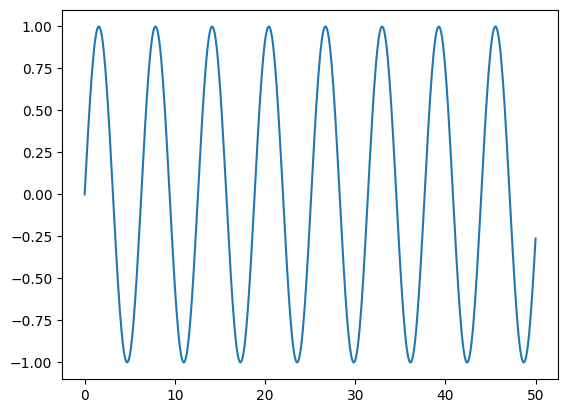

In [3]:
plt.plot(x,y)

In [4]:
df=pd.DataFrame(data=y,index=x,columns=['Sine'])
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [5]:
test_percent=0.1
test_point=np.round(len(df)*test_percent)
test_point

50.0

In [6]:
test_ind=int(len(df)-test_point) #For setting a limit boundary
test_ind

451

In [7]:
train=df.iloc[:test_ind]
test=df.iloc[test_ind:]
len(train),len(test)

(451, 50)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [10]:
length=50
batch_size=1

generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)

In [11]:
len(scaled_train),len(generator) #O/P is 2 less because we set length of 2

(451, 401)

In [12]:
X,y=generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[4.99999116e-01 5.49916225e-01 5.99334579e-01 6.47760405e-01
 6.94709850e-01 7.39713809e-01 7.82322618e-01 8.22110545e-01
 8.58680040e-01 8.91665714e-01 9.20737985e-01 9.45606372e-01
 9.66022399e-01 9.81782075e-01 9.92727935e-01 9.98750612e-01
 9.99789928e-01 9.95835500e-01 9.86926839e-01 9.73152957e-01
 9.54651478e-01 9.31607263e-01 9.04250562e-01 8.72854714e-01
 8.37733417e-01 7.99237589e-01 7.57751870e-01 7.13690771e-01
 6.67494535e-01 6.19624741e-01 5.70559686e-01 5.20789614e-01
 4.70811810e-01 4.21125636e-01 3.72227539e-01 3.24606094e-01
 2.78737119e-01 2.35078919e-01 1.94067715e-01 1.56113277e-01
 1.21594831e-01 9.08572769e-02 6.42077324e-02 4.19124713e-02
 2.41942605e-02 1.12301346e-02 3.14962674e-03 3.34747619e-05
 1.91281421e-03 8.76886734e-03]
Predict this y: 
 [[0.02053313]]


In [13]:
#scaled_train 
#Length=2 means by reviewing first 2 we predict the third number, after that by reviewing 2nd and 3rd we predict 4th and so on

**Using simple RNN**

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

In [15]:
n_features=1

# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(50,input_shape=(length, n_features))) #Using simple RNN

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.fit_generator(generator,epochs=5)

C:\Users\arind\AppData\Local\Temp\ipykernel_1032\1246993970.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=5)


Epoch 1/5
401/401 [==============================] - 6s 10ms/step - loss: 0.0087
Epoch 2/5
401/401 [==============================] - 4s 10ms/step - loss: 5.3736e-05
Epoch 3/5
401/401 [==============================] - 4s 9ms/step - loss: 7.4523e-05
Epoch 4/5
401/401 [==============================] - 4s 10ms/step - loss: 2.1354e-04
Epoch 5/5
401/401 [==============================] - 4s 10ms/step - loss: 5.6911e-05


<Axes: >

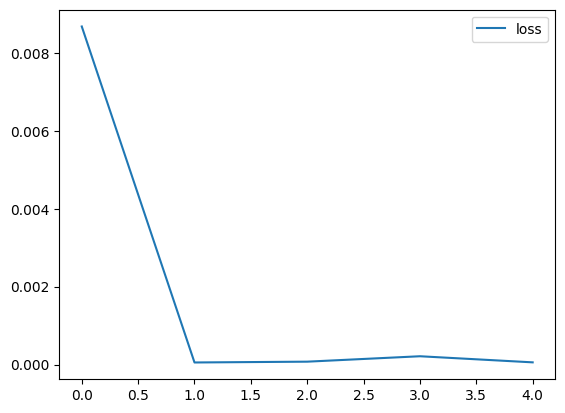

In [18]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 49ms/step


In [26]:
true_predictions = scaler.inverse_transform(test_predictions)

In [27]:
test['Predictions'] = true_predictions

C:\Users\arind\AppData\Local\Temp\ipykernel_1032\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: >

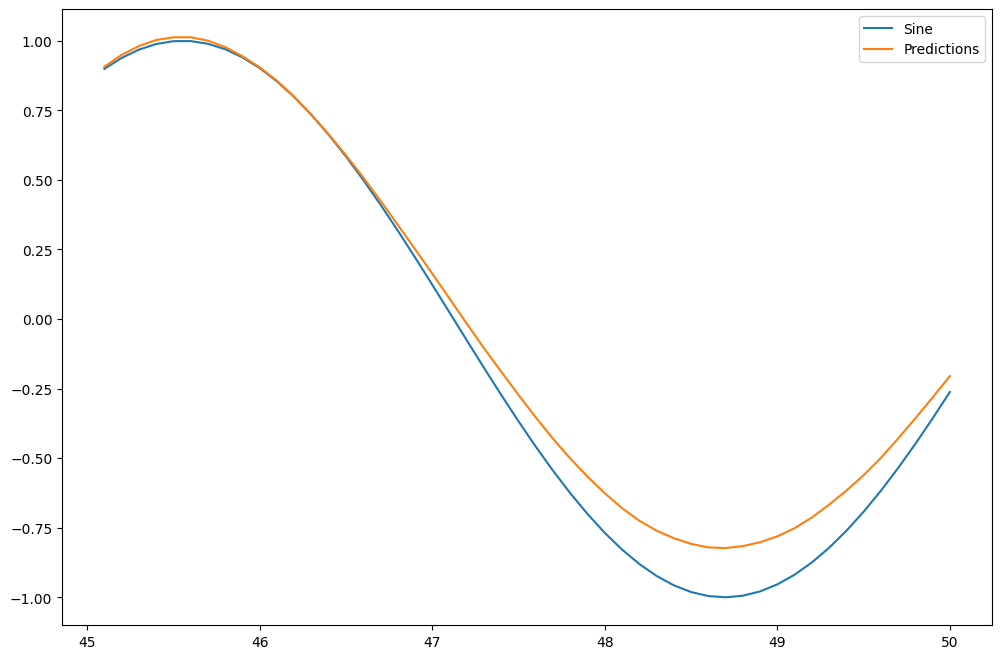

In [28]:
test.plot(figsize=(12,8))

**Using LSTM**

In [29]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [30]:
length = 49
generator = TimeseriesGenerator(scaled_train,scaled_train,
                               length=length,batch_size=1)


validation_generator = TimeseriesGenerator(scaled_test,scaled_test,
                                          length=length,batch_size=1)

In [31]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(50,input_shape=(length, n_features))) #Using LSTM

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [32]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\arind\AppData\Local\Temp\ipykernel_1032\1950115197.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


402/402 [==============================] - 13s 21ms/step - loss: 0.0170 - val_loss: 9.2191e-05
Epoch 2/20
402/402 [==============================] - 7s 17ms/step - loss: 2.2767e-04 - val_loss: 1.5273e-04
Epoch 3/20
402/402 [==============================] - 7s 17ms/step - loss: 3.0627e-04 - val_loss: 4.4840e-05
Epoch 4/20
402/402 [==============================] - 7s 18ms/step - loss: 1.1854e-04 - val_loss: 3.8336e-05
Epoch 5/20
402/402 [==============================] - 6s 16ms/step - loss: 6.9228e-05 - val_loss: 4.4134e-05
Epoch 6/20
402/402 [==============================] - 7s 16ms/step - loss: 7.5812e-05 - val_loss: 1.6608e-06
Epoch 7/20
402/402 [==============================] - 7s 18ms/step - loss: 5.6544e-04 - val_loss: 2.1161e-05
Epoch 8/20
402/402 [==============================] - 7s 18ms/step - loss: 6.6102e-05 - val_loss: 1.2195e-05


In [33]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 58ms/step


C:\Users\arind\AppData\Local\Temp\ipykernel_1032\2075574314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Predictions'] = true_predictions


<Axes: >

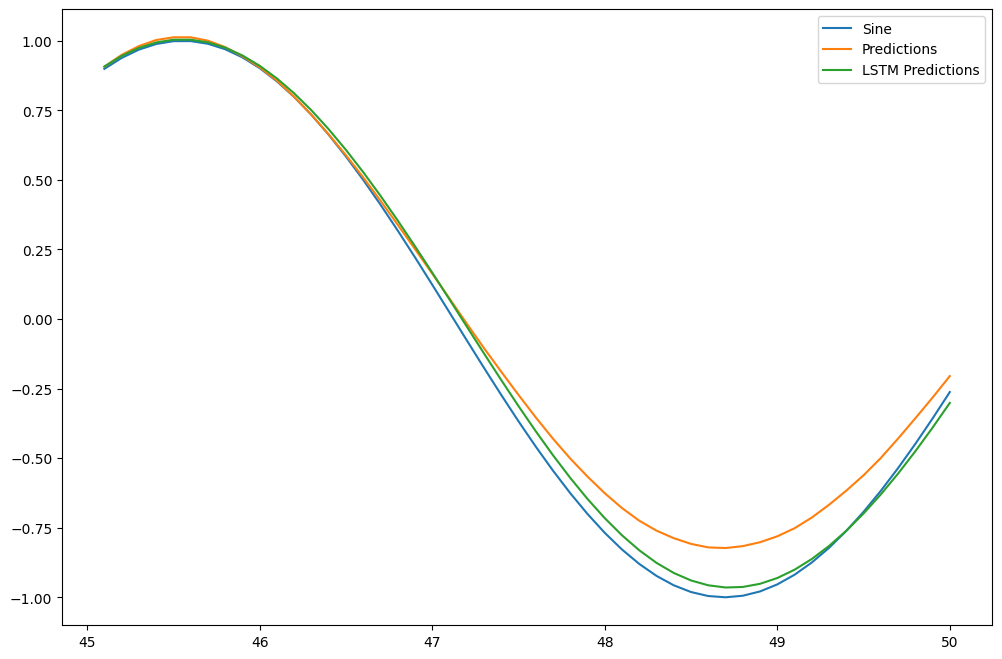

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions #How well the LSTM performs

# Forecasting

In [35]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [36]:
length = 50 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [37]:
model = Sequential()
model.add(LSTM(50, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=6)

Epoch 1/6


C:\Users\arind\AppData\Local\Temp\ipykernel_1032\2968077443.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=6)


451/451 [==============================] - 14s 18ms/step - loss: 0.0172
Epoch 2/6
451/451 [==============================] - 8s 18ms/step - loss: 1.4206e-04
Epoch 3/6
451/451 [==============================] - 8s 18ms/step - loss: 1.4225e-04
Epoch 4/6
451/451 [==============================] - 9s 19ms/step - loss: 1.5406e-04
Epoch 5/6
451/451 [==============================] - 8s 18ms/step - loss: 1.1585e-04
Epoch 6/6
451/451 [==============================] - 8s 17ms/step - loss: 2.2086e-04


In [38]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 58ms/step


In [39]:
forecast = scaler.inverse_transform(forecast)

In [40]:
forecast_index = np.arange(50.1,55.1,step=0.1)

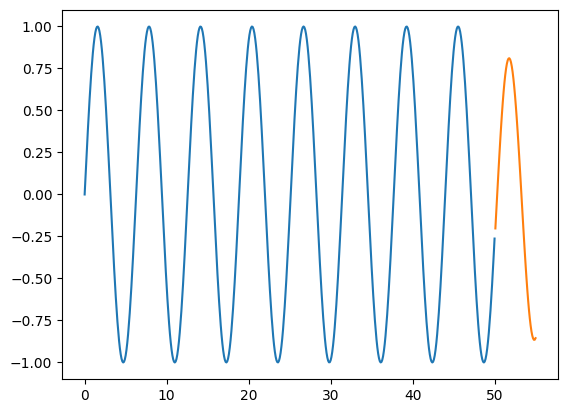

In [41]:
plt.plot(df.index,df['Sine'])
plt.plot(forecast_index,forecast)